# Import necessary Libraries

In [ ]:
import os
import shutil
import cv2
import numpy as np
import json

from math import sqrt
from google.colab.patches import cv2_imshow

# Install Ultralytics and Import YOLO

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO


Ultralytics YOLOv8.2.14 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/107.7 GB disk)


In [ ]:
# Load a pretrained YOLOv8x model
model = YOLO('yolov8x.pt')

# Define path to directory containing 100 images for inference
source = '/content/drive/MyDrive/SF/CAR_folder'
model.predict(source, classes=[2,5,7], save=True, save_txt=True, conf=0.35)


# Move Detected labels in secure folder "Detections"

In [ ]:
# Define paths
prediction_folder = "runs/detect/predict3"
OUT_folder = "/content/drive/MyDrive/SF/Detections"

# Create OUT folder if it doesn't exist
os.makedirs(OUT_folder, exist_ok=True)

# Iterate through prediction folder
for root, _, files in os.walk(prediction_folder):
    for file in files:
        if file.endswith(".txt"):
            shutil.move(os.path.join(root, file), os.path.join(OUT_folder, file))

print("Processed labels moved to Detections folder.")

# Function to project all LiDAR and RADAR points on Image

In [ ]:
def project_all_points_onto_image(calibration_data, image_size, camera_calibration, lidar_calibration, radar_calibration, lidar_points, radar_points):
    """Project LiDAR and RADAR points onto the image."""
    filtered_indices_lidar = []
    filtered_indices_radar = []

    for sensor in calibration_data['sensors']:
        if sensor['sensor_uid'] == 'camera_front':
            camera_calibration = sensor['calib_data']
        elif sensor['sensor_uid'] == 'lidar_vlp16':
            lidar_calibration = sensor['calib_data']
        elif sensor['sensor_uid'] == 'radar_6455':
            radar_calibration = sensor['calib_data']

    if camera_calibration is None or lidar_calibration is None or radar_calibration is None:
        print("Camera or LiDAR or Radar calibration data not found!")
        return None, None

    K = np.array(camera_calibration['K'])
    T_camera = np.array(camera_calibration['T_to_ref_COS'])

    lidar_to_camera = np.linalg.inv(T_camera) @ np.array(lidar_calibration['T_to_ref_COS'])
    radar_to_camera = np.linalg.inv(T_camera) @ np.array(radar_calibration['T_to_ref_COS'])

    # Project LiDAR points onto the image
    lidar_points_projected = []
    for point in lidar_points:
        xyz = np.array([point[0], point[1], point[2], 1])
        xyz = lidar_to_camera @ xyz
        uv = K @ xyz[:3]
        uv /= uv[2]  # Normalize by Z coordinate
        lidar_points_projected.append(uv[:2])

    # Project RADAR points onto the image
    radar_points_projected = []
    for point in radar_points:
        xyz = np.array([point[0], point[1], point[2], 1])
        xyz = radar_to_camera @ xyz
        uv = K @ xyz[:3]
        uv /= uv[2]  # Normalize by Z coordinate
        radar_points_projected.append(uv[:2])

    return lidar_points_projected, radar_points_projected



# Function Definations for loading specific data

In [ ]:
def load_calibration_data(base_dir, photo):
    """Load calibration data."""
    with open(os.path.join(base_dir, f"dataset_astyx_hires2019/dataset_astyx_hires2019/calibration/{photo:06d}.json"), 'r') as f:
        return json.load(f)

def load_point_clouds(base_dir, photo, lidar=True, radar=True):
    """Load LiDAR and RADAR point clouds."""
    lidar_points = []
    radar_points = []

    with open(os.path.join(base_dir, f"dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{photo:06d}.txt"), 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.strip() and not line.startswith('X'):  # Skip empty lines and header
                lidar_points.append([float(x) for x in line.split()])
        lidar_points = np.array(lidar_points)

    if radar:
        with open(os.path.join(base_dir, f"dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{photo:06d}.txt"), 'r') as f:
            lines = f.readlines()[2:]  # Skip the first two lines
            for line in lines:
                radar_points.append([float(x) for x in line.split()])
        radar_points = np.array(radar_points)

    return lidar_points if lidar else None, radar_points if radar else None

def load_bounding_boxes(labels_folder, image_name, image):
    """Load bounding boxes from labels file."""
    detected_bounding_boxes = []
    with open(os.path.join(labels_folder, f"{image_name}.txt"), 'r') as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.split())
            x_center *= image.shape[1]
            y_center *= image.shape[0]
            width *= image.shape[1]
            height *= image.shape[0]
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)
            detected_bounding_boxes.append([x_min, y_min, x_max, y_max])

    return detected_bounding_boxes

# Function for Projecting and filtering points clouds on all images in directory

In [ ]:
def project_points_onto_image(calibration_data, image_size, camera_calibration, lidar_calibration, radar_calibration, lidar_points, radar_points, bboxes):
    """Project LiDAR and RADAR points onto the image for each bounding box."""
    filtered_indices_lidar_list = []
    filtered_indices_radar_list = []

    for bbox in bboxes:
        camera_calibration = None
        lidar_calibration = None
        radar_calibration = None
        for sensor in calibration_data['sensors']:
            if sensor['sensor_uid'] == 'camera_front':
                camera_calibration = sensor['calib_data']
            elif sensor['sensor_uid'] == 'lidar_vlp16':
                lidar_calibration = sensor['calib_data']
            elif sensor['sensor_uid'] == 'radar_6455':
                radar_calibration = sensor['calib_data']

        if camera_calibration is None or lidar_calibration is None or radar_calibration is None:
            print("Camera or LiDAR or Radar calibration data not found!")
            continue

        K = np.array(camera_calibration['K'])
        T_camera = np.array(camera_calibration['T_to_ref_COS'])
        T_lidar = np.array(lidar_calibration['T_to_ref_COS'])
        T_radar = np.array(radar_calibration['T_to_ref_COS'])

        lidar_to_camera = np.linalg.inv(T_camera) @ T_lidar
        radar_to_camera = np.linalg.inv(T_camera) @ T_radar

        # Filter LiDAR points within the bounding box
        points = []
        filtered_indices_lidar = []
        for point in lidar_points:
            xyz = np.array([point[0], point[1], point[2], 1])
            xyz = lidar_to_camera @ xyz
            uv = K @ xyz[:3]
            uv /= uv[2]  # Normalize by Z coordinate
            if (bbox[0] <= uv[0] <= bbox[2]) and (bbox[1] <= uv[1] <= bbox[3]):
                points.append(uv[:2])
                filtered_indices_lidar.append(point)
        filtered_indices_lidar_list.append(filtered_indices_lidar)

        # Filter RADAR points within the bounding box
        points = []
        filtered_indices_radar = []
        for point in radar_points:
            xyz = np.array([point[0], point[1], point[2], 1])
            xyz = radar_to_camera @ xyz
            uv = K @ xyz[:3]
            uv /= uv[2]  # Normalize by Z coordinate
            if (bbox[0] <= uv[0] <= bbox[2]) and (bbox[1] <= uv[1] <= bbox[3]):
                points.append(uv[:2])
                filtered_indices_radar.append(point)
        filtered_indices_radar_list.append(filtered_indices_radar)

    return filtered_indices_lidar_list, filtered_indices_radar_list

# Function definations to calculate individual sensor's distance

In [ ]:

def calculate_distances(filtered_indices_lidar_list, filtered_indices_radar_list, image_size, bboxes):
    """Calculate median distances for LiDAR and RADAR points for each bounding box."""
    median_lidar_distances = []
    median_radar_distances = []

    for lidar_points_bbox, radar_points_bbox in zip(filtered_indices_lidar_list, filtered_indices_radar_list):
        if lidar_points_bbox:
            lidar_distances_bbox = [points[0] for points in lidar_points_bbox]
            median_lidar_distances.append(np.median(lidar_distances_bbox))
        else:
            median_lidar_distances.append(None)

        if radar_points_bbox:
            radar_distances_bbox = [points[0] for points in radar_points_bbox]
            median_radar_distances.append(np.median(radar_distances_bbox))
        else:
            median_radar_distances.append(None)

    return median_lidar_distances, median_radar_distances



# Function defination to calculate Weighted average Sensor fusion distance

In [ ]:
def calculate_fused_distances(median_lidar_distances, median_radar_distances):
    """Calculate fused distances for each bounding box."""
    fused_distances = []
    for lidar_distance, radar_distance in zip(median_lidar_distances, median_radar_distances):
        if lidar_distance is not None and radar_distance is not None:
            fused_distance = 0.8 * abs(lidar_distance) + 0.2 * abs(radar_distance)
            fused_distances.append(fused_distance)
        elif lidar_distance is not None:
            fused_distances.append(abs(lidar_distance))
        elif radar_distance is not None:
            fused_distances.append(abs(radar_distance))
        else:
            fused_distances.append(None)

    return fused_distances

# Function to visualize results on 100 Images selected

In [ ]:
def visualize_results(image, bboxes, median_lidar_distances, median_radar_distances, fused_distances):
    """Visualize results on the image."""
    for i, box in enumerate(bboxes, start=1):
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

        # Calculate text positions (adjust based on your preference)
        text_top = y_min - 5  # Above bounding box
        text_bottom = y_max + 15  # Below bounding box
        text_offset = 10  # Text offset from bounding box edge

        # Draw LiDAR distance text
        lidar_text = f"LiDAR: {abs(median_lidar_distances[i - 1]):.2f}m" if median_lidar_distances[i - 1] is not None else "LiDAR: None"
        cv2.putText(image, lidar_text, (x_min + text_offset, text_top), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Draw RADAR distance text
        radar_text = f"RADAR: {abs(median_radar_distances[i - 1]):.2f}m" if median_radar_distances[i - 1] is not None else "RADAR: None"
        cv2.putText(image, radar_text, (x_min + text_offset, text_bottom), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Draw fused distance text
        fused_text = f"FUSED: {abs(fused_distances[i - 1]):.2f}m" if fused_distances[i - 1] is not None else "FUSED: None"
        cv2.putText(image, fused_text, (x_min + text_offset, text_bottom + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return image

# Function to project filtered point on specific Image

In [ ]:
def project_filtered_points_onto_image(calibration_data, image_size, camera_calibration, lidar_calibration, radar_calibration, lidar_points, radar_points, bboxes):
    """Project filtered LiDAR and RADAR points onto the image."""
    lidar_points_projected = []
    radar_points_projected = []

    for sensor in calibration_data['sensors']:
        if sensor['sensor_uid'] == 'camera_front':
            camera_calibration = sensor['calib_data']
        elif sensor['sensor_uid'] == 'lidar_vlp16':
            lidar_calibration = sensor['calib_data']
        elif sensor['sensor_uid'] == 'radar_6455':
            radar_calibration = sensor['calib_data']

    if camera_calibration is None or lidar_calibration is None or radar_calibration is None:
        print("Camera or LiDAR or Radar calibration data not found!")
        return None, None

    K = np.array(camera_calibration['K'])
    T_camera = np.array(camera_calibration['T_to_ref_COS'])

    lidar_to_camera = np.linalg.inv(T_camera) @ np.array(lidar_calibration['T_to_ref_COS'])
    radar_to_camera = np.linalg.inv(T_camera) @ np.array(radar_calibration['T_to_ref_COS'])

    for bbox in bboxes:
        # Project LiDAR points within the bounding box
        for point in lidar_points:
            xyz = np.array([point[0], point[1], point[2], 1])
            xyz = lidar_to_camera @ xyz
            uv = K @ xyz[:3]
            uv /= uv[2]  # Normalize by Z coordinate
            if (bbox[0] <= uv[0] <= bbox[2]) and (bbox[1] <= uv[1] <= bbox[3]):
                lidar_points_projected.append(uv[:2])

        # Project RADAR points within the bounding box
        for point in radar_points:
            xyz = np.array([point[0], point[1], point[2], 1])
            xyz = radar_to_camera @ xyz
            uv = K @ xyz[:3]
            uv /= uv[2]  # Normalize by Z coordinate
            if (bbox[0] <= uv[0] <= bbox[2]) and (bbox[1] <= uv[1] <= bbox[3]):
                radar_points_projected.append(uv[:2])

    return lidar_points_projected, radar_points_projected


# Function to project all lidar and radar points

In [ ]:
def project_all_points_onto_image(calibration_data, image_size, camera_calibration, lidar_calibration, radar_calibration, lidar_points, radar_points):
    """Project LiDAR and RADAR points onto the image."""
    filtered_indices_lidar = []
    filtered_indices_radar = []

    for sensor in calibration_data['sensors']:
        if sensor['sensor_uid'] == 'camera_front':
            camera_calibration = sensor['calib_data']
        elif sensor['sensor_uid'] == 'lidar_vlp16':
            lidar_calibration = sensor['calib_data']
        elif sensor['sensor_uid'] == 'radar_6455':
            radar_calibration = sensor['calib_data']

    if camera_calibration is None or lidar_calibration is None or radar_calibration is None:
        print("Camera or LiDAR or Radar calibration data not found!")
        return None, None

    K = np.array(camera_calibration['K'])
    T_camera = np.array(camera_calibration['T_to_ref_COS'])

    lidar_to_camera = np.linalg.inv(T_camera) @ np.array(lidar_calibration['T_to_ref_COS'])
    radar_to_camera = np.linalg.inv(T_camera) @ np.array(radar_calibration['T_to_ref_COS'])

    # Project LiDAR points onto the image
    lidar_points_projected = []
    for point in lidar_points:
        xyz = np.array([point[0], point[1], point[2], 1])
        xyz = lidar_to_camera @ xyz
        uv = K @ xyz[:3]
        uv /= uv[2]  # Normalize by Z coordinate
        lidar_points_projected.append(uv[:2])

    # Project RADAR points onto the image
    radar_points_projected = []
    for point in radar_points:
        xyz = np.array([point[0], point[1], point[2], 1])
        xyz = radar_to_camera @ xyz
        uv = K @ xyz[:3]
        uv /= uv[2]  # Normalize by Z coordinate
        radar_points_projected.append(uv[:2])

    return lidar_points_projected, radar_points_projected



# Visualize all LiDAR and RADAR points on single Image

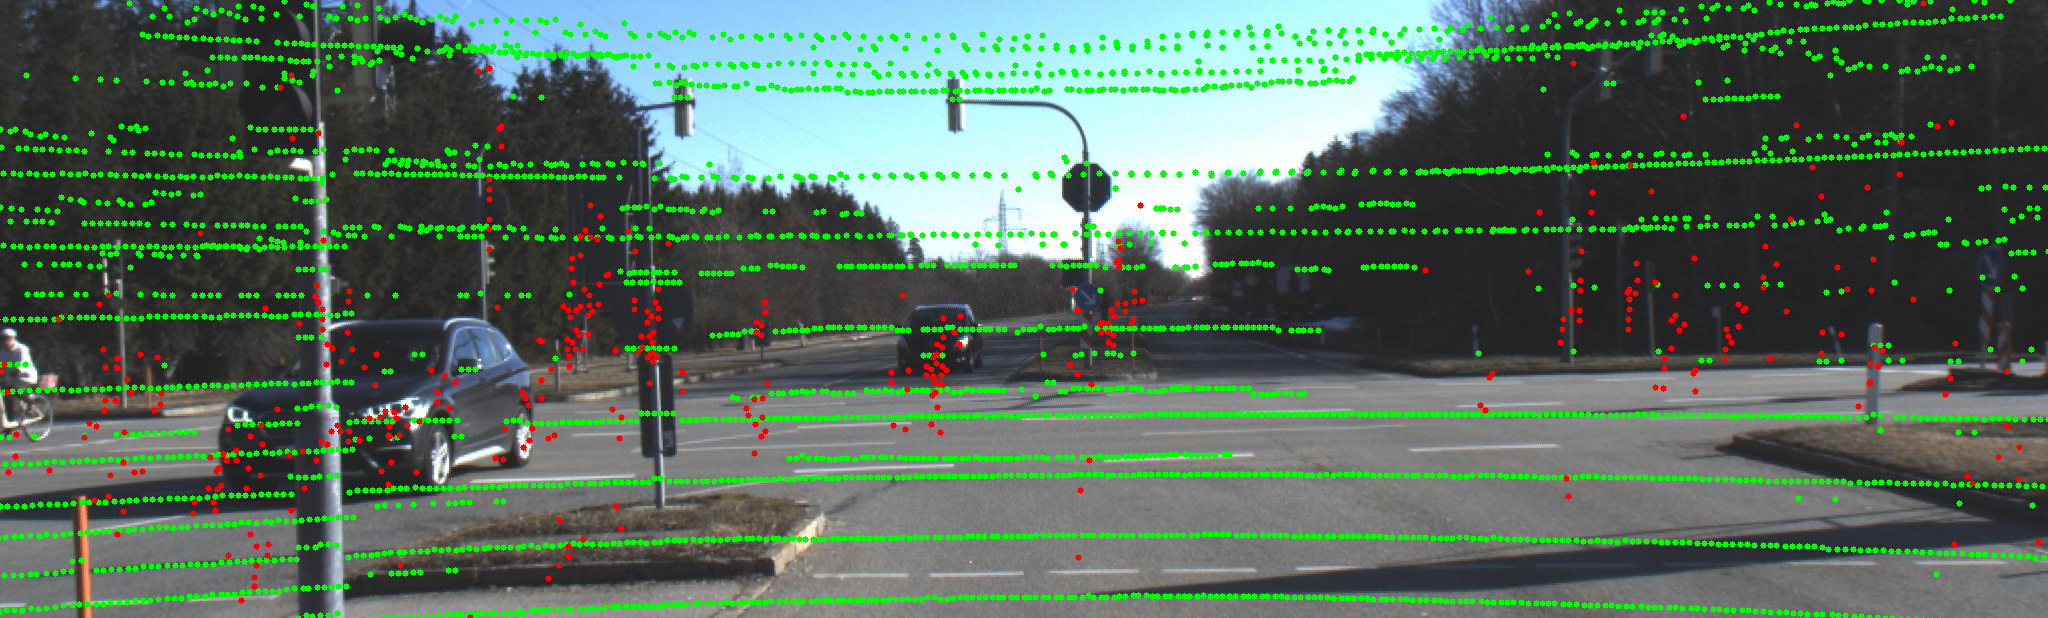

In [ ]:
# Define file paths
base_dir = "/content/drive/MyDrive/SF/"
photo = 486

# Load image and get its size
image_path = os.path.join(base_dir, f"dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{photo:06d}.jpg")
image = cv2.imread(image_path)
image_size = (image.shape[0], image.shape[1])

# Load calibration data
calibration_data = load_calibration_data(base_dir, photo)

# Load LiDAR and RADAR points
lidar_points, radar_points = load_point_clouds(base_dir, photo)

# Project LiDAR and RADAR points onto the image
lidar_points_projected, radar_points_projected = project_all_points_onto_image(calibration_data, image_size, None, None, None, lidar_points, radar_points)

# Visualization
# Draw LiDAR points in green
for point in lidar_points_projected:
    x, y = int(point[0]), int(point[1])
    cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

# Draw RADAR points in red
for point in radar_points_projected:
    x, y = int(point[0]), int(point[1])
    cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

# Display the image with LiDAR and RADAR points visualization
cv2_imshow(image)




# Visualize filtered lidar and radar points on image

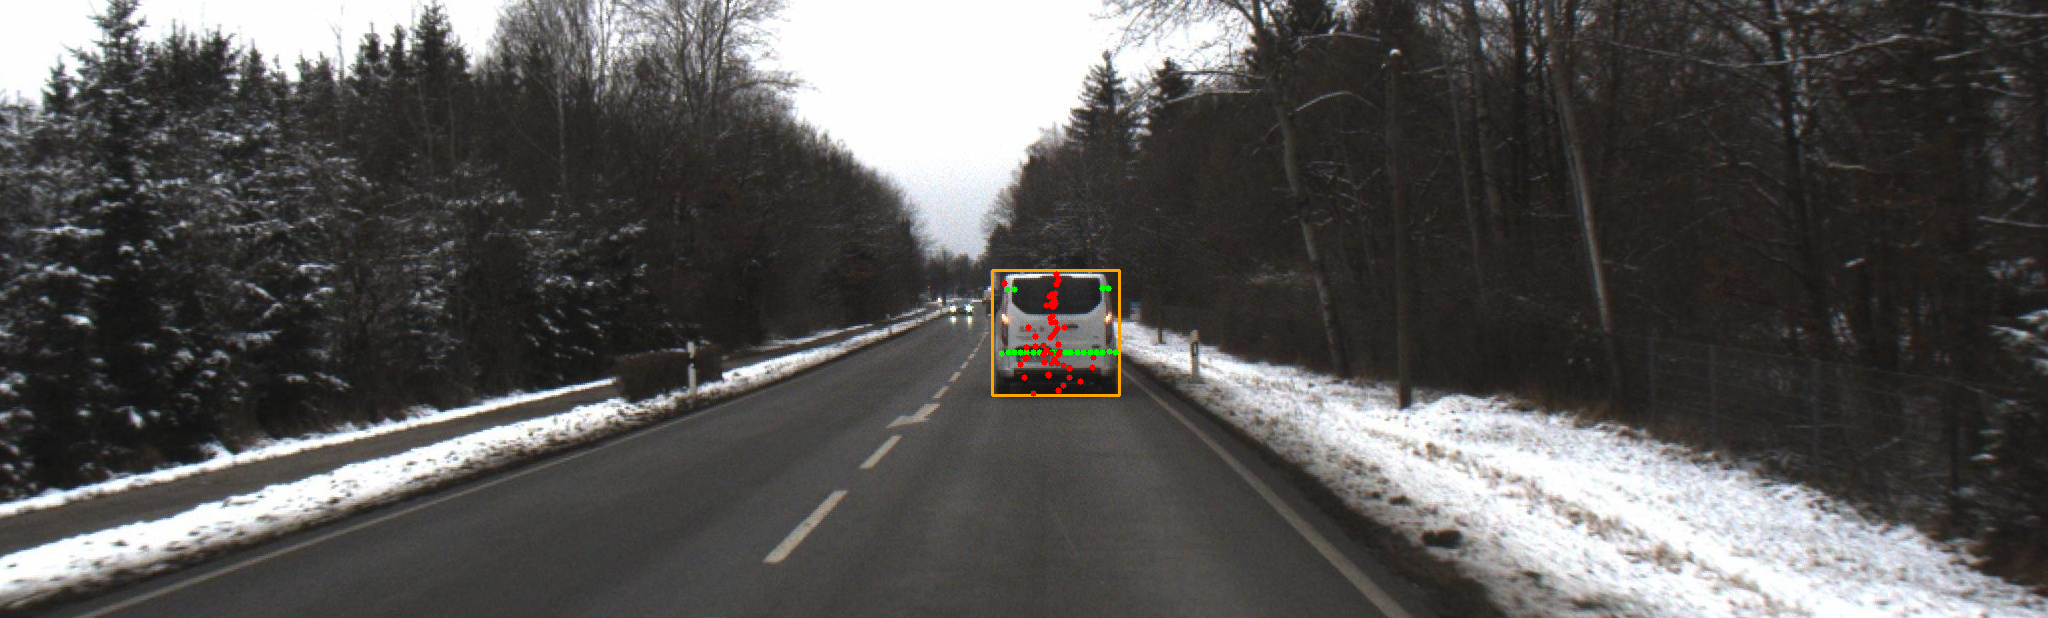

In [ ]:

# Load bounding box information for a specific image number
photo = 131
base_dir = "/content/drive/MyDrive/SF/"
labels_folder = os.path.join(base_dir, "Detections")
image_name = f"{photo:06d}"  # Adjusted the file name pattern
image = cv2.imread(os.path.join(base_dir, "CAR_folder", f"{image_name}.jpg"))  # Load the corresponding image
bboxes = load_bounding_boxes(labels_folder, image_name, image)  # Pass the image to the function

# Load LiDAR and RADAR point cloud data
lidar_points, radar_points = load_point_clouds(base_dir, photo)

# Project filtered LiDAR and RADAR points onto the image
lidar_points_projected, radar_points_projected = project_filtered_points_onto_image(
    calibration_data, image_size, camera_calibration, lidar_calibration, radar_calibration,
    lidar_points, radar_points, bboxes
)

result_image = image.copy()

# Draw bounding boxes
for bbox in bboxes:
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(result_image, (x_min, y_min), (x_max, y_max), (0, 165, 255), 2)

# Visualize the filtered points on the image
for lidar_point in lidar_points_projected:
    x, y = int(lidar_point[0]), int(lidar_point[1])
    cv2.circle(result_image, (x, y), 3, (0, 255, 0), -1)

for radar_point in radar_points_projected:
    x, y = int(radar_point[0]), int(radar_point[1])
    cv2.circle(result_image, (x, y), 3, (0, 0, 255), -1)

# Display the image with filtered projected points
cv2_imshow(result_image)


# Visualize Lidar, Radar and  Weighted distance results on specific Image

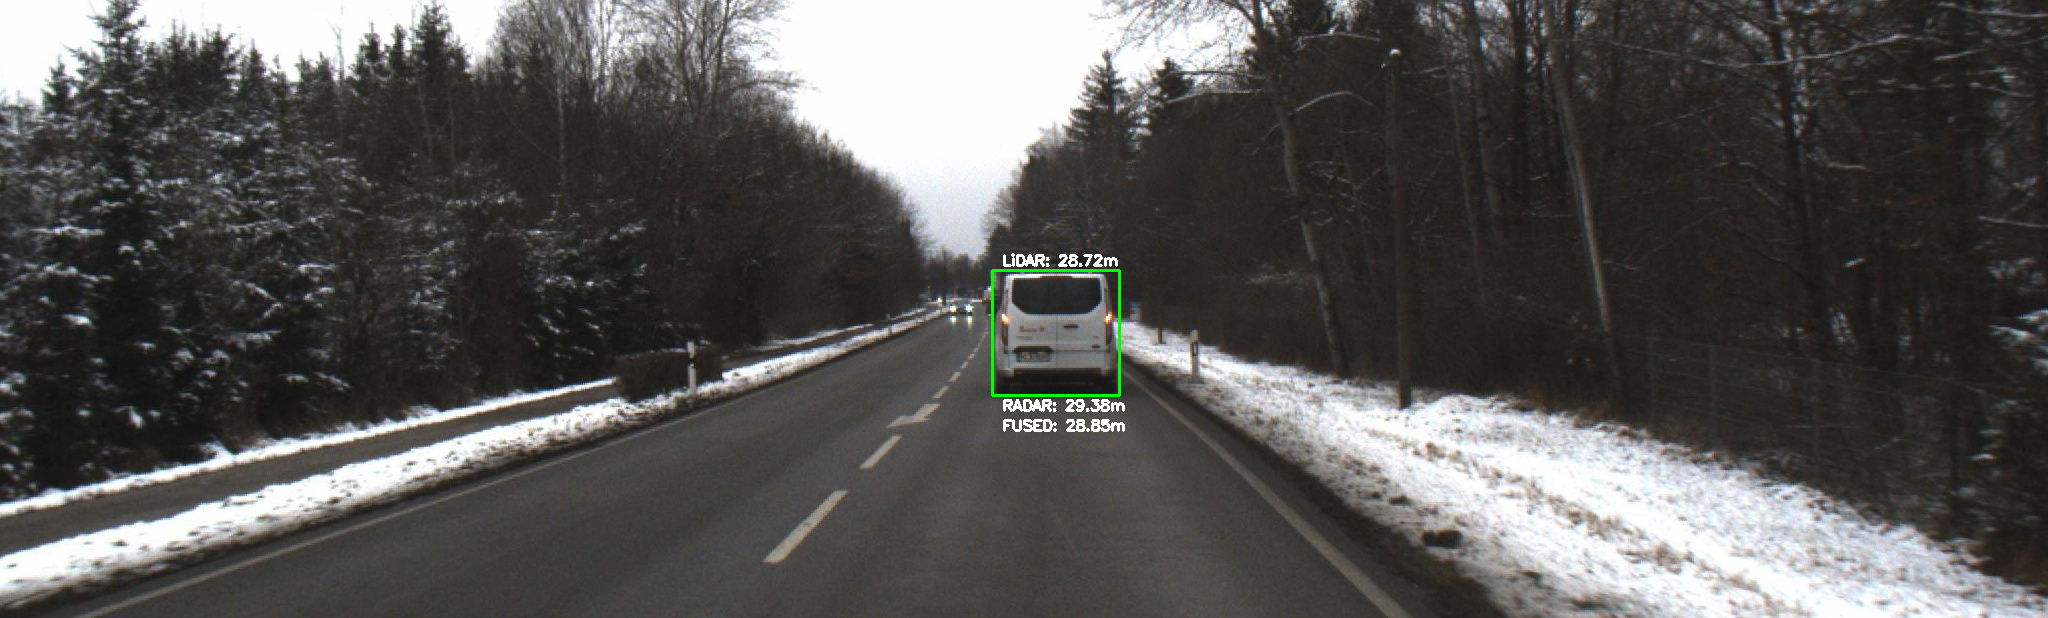

In [ ]:
image_number = 131
base_dir = "/content/drive/MyDrive/SF/"
labels_folder = os.path.join(base_dir, "Detections") #YOLO output labels folder for images
images_folder = os.path.join(base_dir, "CAR_folder")



if __name__ == "__main__":
    # Format the image number with leading zeros
    formatted_image_number = f"{image_number:06d}"

    # Load image and get its size
    image = cv2.imread(os.path.join(images_folder, f"{formatted_image_number}.jpg"))
    if image is None:
        print(f"Failed to load image {formatted_image_number}.jpg.")
    else:
        # Load calibration data
        calibration_data = load_calibration_data(base_dir, image_number)

        # Load LiDAR and RADAR point clouds
        lidar_points, radar_points = load_point_clouds(base_dir, image_number)

        # Load bounding boxes from labels file
        bboxes = load_bounding_boxes(labels_folder, formatted_image_number, image)

        # Find the required calibration data
        camera_calibration = None
        lidar_calibration = None
        radar_calibration = None
        for sensor in calibration_data['sensors']:
            if sensor['sensor_uid'] == 'camera_front':
                camera_calibration = sensor['calib_data']
            elif sensor['sensor_uid'] == 'lidar_vlp16':
                lidar_calibration = sensor['calib_data']
            elif sensor['sensor_uid'] == 'radar_6455':
                radar_calibration = sensor['calib_data']

        if not camera_calibration or not lidar_calibration or not radar_calibration:
            print(f"Skipping image {formatted_image_number} due to missing calibration data.")
        else:
            # Project LiDAR and RADAR points onto the image for each bounding box
            filtered_indices_lidar_list, filtered_indices_radar_list = project_points_onto_image(calibration_data, image.shape[:2], camera_calibration, lidar_calibration, radar_calibration, lidar_points, radar_points, bboxes)

            # Calculate median distances for LiDAR and RADAR points for each bounding box
            median_lidar_distances, median_radar_distances = calculate_distances(filtered_indices_lidar_list, filtered_indices_radar_list, image.shape[:2], bboxes)

            # Calculate fused distances for each bounding box
            fused_distances = calculate_fused_distances(median_lidar_distances, median_radar_distances)

            # Visualization
            image = visualize_results(image, bboxes, median_lidar_distances, median_radar_distances, fused_distances)
            cv2_imshow(image)


# Visualize all 100 images with Lidar, Radar and Sensor fusion distance

In [ ]:
def main(base_dir):
    """Main function."""

    # Create a dictionary to store fused distances categorized by image names and bounding box indices
    fused_distances_dict = {}

    # Iterate through all image files in the folder
    for image_file in os.listdir(images_folder):
        if image_file.endswith((".jpg", ".jpeg", ".png")):
            image_name = os.path.splitext(image_file)[0]
            photo = int(image_name)

            # Load calibration data
            calibration_data = load_calibration_data(base_dir, photo)

            # Load LiDAR and RADAR point clouds
            lidar_points, radar_points = load_point_clouds(base_dir, photo)

            # Load image and get its size
            image = cv2.imread(os.path.join(images_folder, image_file))
            image_size = (image.shape[0], image.shape[1])

            # Load bounding boxes from labels file
            bboxes = load_bounding_boxes(labels_folder, image_name, image)

            # Find the required calibration data
            camera_calibration = None
            lidar_calibration = None
            radar_calibration = None
            for sensor in calibration_data['sensors']:
                if sensor['sensor_uid'] == 'camera_front':
                    camera_calibration = sensor['calib_data']
                elif sensor['sensor_uid'] == 'lidar_vlp16':
                    lidar_calibration = sensor['calib_data']
                elif sensor['sensor_uid'] == 'radar_6455':
                    radar_calibration = sensor['calib_data']

            if not camera_calibration or not lidar_calibration or not radar_calibration:
                print(f"Skipping image {image_name} due to missing calibration data.")
                continue

            # Project LiDAR and RADAR points onto the image for each bounding box
            filtered_indices_lidar_list, filtered_indices_radar_list = project_points_onto_image(calibration_data, image_size, camera_calibration, lidar_calibration, radar_calibration, lidar_points, radar_points, bboxes)

            # Calculate median distances for LiDAR and RADAR points for each bounding box
            median_lidar_distances, median_radar_distances = calculate_distances(filtered_indices_lidar_list, filtered_indices_radar_list, image_size, bboxes)

            # Calculate fused distances for each bounding box
            fused_distances = calculate_fused_distances(median_lidar_distances, median_radar_distances)

            # Store fused distances in the dictionary
            fused_distances_dict[image_name] = fused_distances

            # Visualization (using Colab's cv2_imshow)
            image = visualize_results(image, bboxes, median_lidar_distances, median_radar_distances, fused_distances)
            cv2_imshow(image)


if __name__ == "__main__":
    base_dir = "/content/drive/MyDrive/SF/"
    labels_folder = os.path.join(base_dir, "Detections")
    images_folder = os.path.join(base_dir, "CAR_folder")
    main(base_dir)

# Calculate groundtruth distances and store as a list in list a (lista)

In [ ]:
def load_data(filename):
    """
    Loads the data from a file.

    Args:
        filename: The filename containing the data in JSON format.

    Returns:
        A dictionary containing the frame information and object data.
    """
    with open(filename, 'r') as f:
        data_string = f.read()
    return eval(data_string)

def extract_depth_info(data, image_name, depth_dict):
    """
    Extracts depth information for cars, buses, and trucks from the data.

    Args:
        data: A dictionary containing the frame information and object data.
        image_name: Name of the corresponding image file.
        depth_dict: Dictionary to store depth information for each image.

    Returns:
        None
    """
    depths = []

    for obj in data["objects"]:
        if obj["classname"].lower() in ("car", "bus", "truck"):
            depth = abs(obj["center3d"][0])  # Assuming z is depth (positive)
            depths.append(depth)

    depth_dict[image_name] = depths

def process_data_folder(data_folder, image_folder):
    """
    Processes all image files in the image_folder and finds corresponding JSON files in the data_folder.

    Args:
        data_folder: Path to the directory containing JSON files.
        image_folder: Path to the directory containing image files.

    Returns:
        lista: A list of lists containing depth information for each image.
    """
    # List all image files in the image folder and sort them
    image_files = sorted([file for file in os.listdir(image_folder) if file.endswith('.jpg')])

    # Dictionary to store depth information for each image
    depth_dict = {}

    for image_file in image_files:
        try:
            # Extract image name without extension
            image_name = os.path.splitext(image_file)[0]

            # Construct path to corresponding JSON file
            json_path = os.path.join(data_folder, image_name + '.json')

            # Load JSON data
            data = load_data(json_path)

            # Extract depth information
            extract_depth_info(data, image_name, depth_dict)

        except FileNotFoundError:
            print(f"Error: JSON file for image '{image_name}' not found.")
        except Exception as e:
            print(f"An error occurred while processing the data: {e}")

    # Initialize lista
    lista = []

    # Print the depth information and populate lista
    for image_name, depths in depth_dict.items():
        print(f"{image_name}: {depths}")
        lista.append(depths)

    return lista

# Specify the paths to the data and image folders
data_folder = "/content/drive/MyDrive/SF/dataset_astyx_hires2019/dataset_astyx_hires2019/groundtruth_obj3d"
image_folder = "/content/drive/MyDrive/SF/CAR_folder"

# Process the data folder and get lista
lista = process_data_folder(data_folder, image_folder)

# Print lista
print(lista)


# Remove the distance information where we do not have any lidar or radar point in bounding box and Make a list b (listb) to store weighted average distance.

In [ ]:
def print_depth_info(fused_distances_dict):
    """
    Prints depth information stored in the fused_distances_dict and creates listb.

    Args:
        fused_distances_dict: Dictionary containing depth information for each image.

    Returns:
        listb: A list containing filtered fused distances categorized by image names.
    """
    unique_depths_by_image = {}  # Dictionary to store unique depths categorized by image names
    listb = []

    # Sort image names in ascending order
    sorted_image_names = sorted(fused_distances_dict.keys())

    # Iterate through sorted image names and process corresponding data
    for image_name in sorted_image_names:
        fused_depths = fused_distances_dict[image_name]
        unique_depths = []
        unique_depths_set = set()  # Set to keep track of unique depths

        for depth in fused_depths:
            if depth is not None and depth not in unique_depths_set:
                unique_depths.append(depth)
                unique_depths_set.add(depth)
        unique_depths_by_image[image_name] = unique_depths

    # Print fused depths categorized by image names and populate listb
    for image_name, unique_depths in unique_depths_by_image.items():
        formatted_depths = [round(depth, 22) if depth is not None else "No depth information" for depth in unique_depths]
        print(f"{image_name}: {formatted_depths}")
        listb.append(formatted_depths)

    return listb

# Example usage with fused_distances_dict
listb = print_depth_info(fused_distances_dict)

# Print listb
print(listb)


# Update listb to match the shape of groundtruth list: lista by padding or truncation

In [ ]:
def update_listb(listb, lista):
    updated_listb = []  # Initialize the updated listb

    # Find the maximum length among all inner lists in listb
    max_len = max(len(b) for b in listb)

    # Iterate through each inner list in listb and lista
    for b, a in zip(listb, lista):
        filtered_b = []  # Initialize the filtered inner list

        # Pad listb with extra values from lista if lista has more elements
        if len(a) > len(b):
            b_padded = b + [a[i] for i in range(len(b), len(a))]  # Pad with extra values from lista
        else:
            b_padded = b[:]  # Otherwise, keep listb as it is

        remaining_elements = b_padded[:]  # Make a copy for comparison

        # Find the closest element in listb for each element in lista
        for a_element in a:
            closest_distance = float('inf')  # Initialize the closest distance
            closest_element = None  # Initialize the closest element

            # Find the closest element in b_padded
            for b_element in remaining_elements:
                distance = abs(b_element - a_element)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_element = b_element

            # Check if the closest element is found
            if closest_element is not None:
                filtered_b.append(closest_element)  # Add the closest element to the filtered list

                # Remove the matched element from remaining_elements
                remaining_elements.remove(closest_element)

        updated_listb.append(filtered_b)  # Add the filtered inner list to the updated listb

    return updated_listb

# Example usage with listb and lista
updated_listb = update_listb(listb, lista)

# Print updated_listb
print(updated_listb)


# Calculate accuracy evaluation metrics MAE and RMSE

In [ ]:
def calculate_mae_rmse(ground_truth_lists, estimated_lists):
    """
    Calculates Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for multiple lists.

    Args:
        ground_truth_lists: List of lists containing ground truth values.
        estimated_lists: List of lists containing estimated values.

    Returns:
        A dictionary containing average MAE and RMSE across all lists.
    """

    if len(ground_truth_lists) != len(estimated_lists):
        raise ValueError("Ground truth and estimated lists must have the same length")

    total_mae = 0
    total_rmse = 0
    num_lists = len(ground_truth_lists)

    for gt_list, est_list in zip(ground_truth_lists, estimated_lists):
        if len(gt_list) != len(est_list):
            continue  # Skip pairs with different lengths

        # Calculate absolute differences
        absolute_differences = [abs(gt - est) for gt, est in zip(gt_list, est_list)]

        # Calculate MAE for this list
        mae = sum(absolute_differences) / len(absolute_differences)

        # Calculate squared differences
        squared_differences = [(gt - est) ** 2 for gt, est in zip(gt_list, est_list)]

        # Calculate RMSE for this list
        rmse = sqrt(sum(squared_differences) / len(squared_differences))

        total_mae += mae
        total_rmse += rmse

    # Average MAE and RMSE across all lists
    average_mae = total_mae / num_lists
    average_rmse = total_rmse / num_lists

    return {"average_mae": average_mae, "average_rmse": average_rmse}


results = calculate_mae_rmse(lista, updated_listb)

print("Average MAE:", results["average_mae"])
print("Average RMSE:", results["average_rmse"])



Average MAE: 5.4970156021051775
Average RMSE: 6.673511258034214
